In [3]:
import httpx
import base64
from rasterio.io import MemoryFile
from rasterio.plot import show
import numpy as np
from base64 import b64decode
import rasterio
from rasterio import features

In [4]:
URL = "https://cerulean-cloud-test-cloud-run-orchestrator-943124-5qkjkyomta-ew.a.run.app"

In [5]:
orchestrator_result = httpx.post(URL+"/orchestrate", json={"sceneid": "S1A_IW_GRDH_1SDV_20200729T034859_20200729T034924_033664_03E6D3_93EF"}, timeout=None)


print(orchestrator_result)
# Takes 10min for 1 scene syncronously
# 1 min 6s with 3 concurrency

<Response [200 OK]>


In [6]:
result = orchestrator_result.json()
print(result.keys())

dict_keys(['base_inference', 'offset_inference', 'ntiles', 'noffsettiles'])


[0 1 2 3 4 5 6 7 8]
2 0


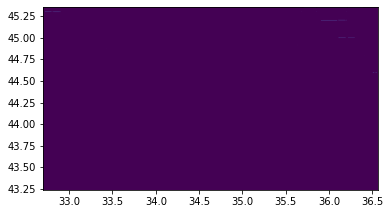

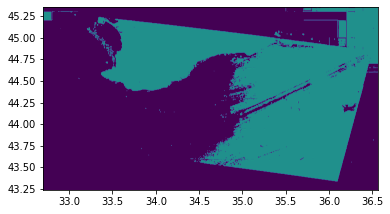

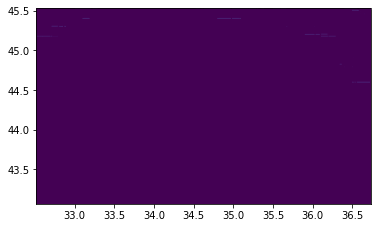

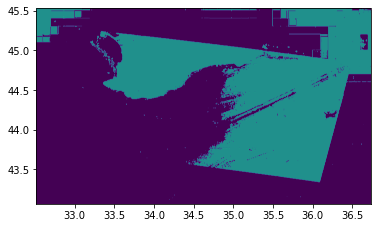

In [7]:
with MemoryFile(b64decode(result["base_inference"])) as memfile:
        with memfile.open() as dataset:
            np_img = dataset.read()
            assert np_img.shape == (2, 3072, 5632)
            print(np.unique(np_img[0,:,:]))
            print(np.amax(np_img[1,:,:]), np.amin(np_img[1,:,:]))
            show((dataset,1))
            show((dataset,2))
with MemoryFile(b64decode(result["offset_inference"])) as memfile:
    with memfile.open() as dataset:
        np_img = dataset.read()
        assert np_img.shape == (2, 3584, 6144)
        show((dataset,1))
        show((dataset,2))
        with rasterio.open("offset_inference.tiff", **dataset.profile, mode="w") as dst:
            dst.write(np_img)

In [28]:
with MemoryFile(b64decode(result["base_inference"])) as memfile:
        with memfile.open() as dataset:
            shapes = features.shapes(dataset.read(1).astype("uint8"), transform=dataset.transform)



In [29]:
import geojson
out_fc = geojson.FeatureCollection(features=[geojson.Feature(geometry=geom, properties=dict(classification=classification)) for geom, classification in shapes])
with open("output_vector.json", "w") as dst:
    geojson.dump(out_fc, dst)